In [54]:
'''
Look into outputs. 

Phonemes labels are at the end of each line. 

Get average length of phoneme. 

Get the mean feature, the average, everything from post two weeks. 

Change kevin's code in your directory to write outputs to output dir.

Find out which files were affected in Kevin's dataset. Replace them.
'''
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import umap

In [287]:
ALL_PHONEMES = ['iy',  'ux',  'eh',  'ix',  'ao',  'aa',  'ax-h',  'ih',  'uh',  'ah',  'uw',  'ax',  'ae',  'ay',  'aw',   'ey',
 'ow',  'oy',  'y',  'er',  'l','el','axr','w','r','t','p','d','jh','b','g','ch','k','v','dh','th','hv','s','zh','f','z','hh','sh','nx','m','en','em','n','eng','ng','pau','bcl','pcl','tcl','epi','q','dcl','h','dx','gcl','kcl','h#']

In [288]:
len(ALL_PHONEMES)

62

# Getting Average Length of Features

In [20]:
# check if file has been opened
def is_timit_txt_file_processed(filename): # checks if file is shorter than 1000 kb
    return os.path.getsize(filename) > 1000

def is_timit_txt_file_processe2(filename): # slower because it opens files and checks if it is only one line (the sentence spoken as obseved in timit dataset) or multiple. use as confirmation
    f = open(filename, "r")
    lines = f.readlines()
    return not len(lines)==1

In [3]:
'''
Look into outputs. 
Open each file and read line by line. get number of lines for each file
add them into all files
find average for each phoneme
find weighted average for all phonemes

NOTES:
each line is 131 long, phoneme inclusive
'''
def get_phonemes_features_lengths_single_file(filename):
    '''
    gets the number of feature lines corresponding to each phoneme in a file
    
    input:
        filename (str): the name of the file
    
    output:
        phonemes_to_lengths (dict): a map of the phoneme to a list of the number of feature lines corresponding to each occurence of the phoneme. For example, if the aa phoneme occurs twice in the input file and the first time is 15 line and the second is 20 lines long, the output will include 'aa': [15,20]
    '''
    previous_phoneme = ""
    phonemes_to_lengths = {}
    f = open(filename, "r")
    lines = f.readlines()
    for line in lines: 
        phoneme = line.split()[-1]
        if phoneme in phonemes_to_lengths: # repeat occurence of phoneme
            if phoneme == previous_phoneme: # still same phoneme, increment count
                phonemes_to_lengths[phoneme][-1] += 1
            else: # different phoneme, start counter for phoneme
                phonemes_to_lengths[phoneme].append(1)
        else: # first occurence of phoneme
            phonemes_to_lengths[phoneme] = [1]
        previous_phoneme = phoneme
    return phonemes_to_lengths

In [4]:
filename = "Y:/personal/ojuba.mezisashe/timit_dp_test_extract_features/TRAIN/DR1/FCJF0/SI648.txt"
print(get_phonemes_features_lengths_single_file(filename))

{'h#': [44, 62], 'ax-h': [20, 10], 's': [53, 52], 'ey': [51, 43], 'l': [7, 26], 'v': [17, 23], 'ow': [56, 79], 'q': [10, 25], 'm': [32, 28, 37], 'hv': [40, 25], 'ae': [55], 'ax': [25], 'bcl': [35, 22], 'b': [12, 18], 'n': [15, 36, 34, 17, 22, 34], 'ih': [46, 36, 26], 'axr': [26], 'tcl': [37, 18], 't': [23, 21], 'iy': [50], 'dh': [38, 11], 'w': [35], 'ah': [30], 'ix': [22, 15], 'ay': [48], 'kcl': [24, 51], 'k': [37], 'aa': [60], 'eh': [86]}


In [12]:
'''
get list of all files.
iterate through all files, use get_phonemes_features_lengths_single_file(filename)
integrate outputs into single output
get average per phoneme and total weighted average
'''

# get list of all files
files_searching = [] # list of all files that will be used in getting weighted average
directory_train_or_dev = "Y:\\personal\\ojuba.mezisashe\\timit_dp_test_extract_features\\TRAIN" # should be of depth = (dev, test, or train) in timit dataset
for current_directory,subfolders,files in list(os.walk(directory_train_or_dev))[2:]:
    for file in files:
        file = current_directory + "\\" + file
        if file.lower().endswith(".txt"):
            if is_timit_txt_file_processed(file): 
                files_searching.append(file)

In [23]:
# iterate through all files, use get_phonemes_features_lengths_single_file(filename)
# integrate outputs into single output
phonemes_to_lengths = {}
for file in files_searching:
    phonemes_to_lengths_single_file = get_phonemes_features_lengths_single_file(file)
    for phoneme in phonemes_to_lengths_single_file:
        if phoneme in phonemes_to_lengths:
            phonemes_to_lengths[phoneme].extend(phonemes_to_lengths_single_file[phoneme])
        else:
            phonemes_to_lengths[phoneme] = phonemes_to_lengths_single_file[phoneme]

In [24]:
# get average per phoneme and total weighted average
# total is calculated without 'h#' phoneme
average_phoneme_lengths = {} # get average per phoneme and total weighted average in 'total' key
num_phonemes_total = 0
for phoneme in phonemes_to_lengths:
    average_phoneme_lengths[phoneme] = sum(phonemes_to_lengths[phoneme])/len(phonemes_to_lengths[phoneme])
    num_phonemes_total += len(phonemes_to_lengths[phoneme])

average_phoneme_lengths['total'] = 0
for phoneme in phonemes_to_lengths:
    if phoneme == "h#":
        pass
    else:
        average_phoneme_lengths['total'] += average_phoneme_lengths[phoneme] * (len(phonemes_to_lengths[phoneme])/num_phonemes_total)

In [58]:
average_phoneme_lengths

{'h#': 91.61307901907357,
 'q': 31.835365853658537,
 'iy': 45.330232558139535,
 'v': 30.303030303030305,
 'ih': 38.78341013824885,
 'n': 27.721854304635762,
 'eh': 45.829268292682926,
 'ix': 23.439560439560438,
 'f': 53.99173553719008,
 'sh': 58.641975308641975,
 'tcl': 27.133587786259543,
 't': 24.478021978021978,
 'uh': 35.18181818181818,
 'kcl': 30.07,
 'k': 26.00561797752809,
 'w': 26.726315789473684,
 'ah': 43.03603603603604,
 's': 58.463667820069205,
 'pcl': 34.18181818181818,
 'ow': 64.66265060240964,
 'dcl': 25.246376811594203,
 'd': 12.285714285714286,
 'hh': 32.41463414634146,
 'ae': 71.80714285714286,
 'ch': 44.075,
 'epi': 19.70212765957447,
 'axr': 37.883495145631066,
 'ao': 56.529411764705884,
 'r': 27.349282296650717,
 'bcl': 31.606060606060606,
 'b': 10.18421052631579,
 'aa': 64.97142857142858,
 'ax': 22.910179640718564,
 'em': 46.44444444444444,
 'ng': 29.982142857142858,
 'gcl': 26.723076923076924,
 'g': 14.307692307692308,
 'hv': 33.86486486486486,
 'm': 33.105555555

In [37]:
len(average_phoneme_lengths)

62

In [38]:
manner_of_articulation_map = {"vowels":{"iy","ih", 'eh', 'ae', 'aa', 'ah', 'ao', 'uh', 'uw', 'ux', 'ax', 'ax-h', 'ix'},
                             "dipthongs":{'ey', 'aw', 'ay', 'oy', 'ow'},
                             "semi-vowels": {'l', 'el', 'r', 'w', 'y', 'er', 'axr'},
                             "stops": {'b', 'd', 'g', 'p', 't', 'k', 'jh', 'ch'},
                             "fricatives": {'s', 'sh', 'z', 'zh', 'f', 'th', 'v', 'dh', 'hh', 'hv'},
                             "nasals": {'m', 'em', 'n', 'nx', 'ng', 'eng', 'en'},
                             "silence": {'dx', 'bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'h', 'pau', 'epi', 'q'},
                             "h#": {"h#"}} # from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4100697  3

In [40]:
sum([len(x) for x,y in manner_of_articulation_map.items()])

56

# UMAP visualization

In [ ]:
def get_phonemes_from_single_file(filename, intended_phoneme_feature_matrix_length):
    '''
    this returns a dicitonary mapping phoneme names to numpy matrices of features of the phoneme class of a particular length (padded with nans if data is less than) found in a file
    inputs:
        filename (str): the input file
        intended_phoneme_feature_matrix_length (int): the matrix length intended, such as a weighted average of the phoneme class lengths. if the features are not up to this length, it will be padded
    '''
    output_dictionary = {}
    previous_phoneme = ""
    f = open(filename, "r")
    lines = f.readlines()
    for line in lines: 
        line = line.split()
        current_phoneme = line[-1]
        line = line[:-1]
        
        if current_phoneme == previous_phoneme:
            if len(output_dictionary[current_phoneme][-1])<intended_phoneme_feature_matrix_length:
                output_dictionary[current_phoneme][-1].append(line)
        else:
            if previous_phoneme:
                a = np.empty((len(output_dictionary[previous_phoneme][-1][-1])))
                a[:] = np.nan
                while len(output_dictionary[previous_phoneme][-1])<intended_phoneme_feature_matrix_length:
                    output_dictionary[previous_phoneme][-1].append(a)
            if current_phoneme in output_dictionary:
                output_dictionary[current_phoneme].append([line])
            else:
                output_dictionary[current_phoneme] = [[line]]
        previous_phoneme = current_phoneme
    if output_dictionary:
        a = np.empty((len(output_dictionary[previous_phoneme][-1][-1])))
        a[:] = np.nan
        while len(output_dictionary[previous_phoneme][-1])<intended_phoneme_feature_matrix_length:
            output_dictionary[previous_phoneme][-1].append(a)
    
    for phoneme in output_dictionary:
        output_dictionary[phoneme] = np.array(output_dictionary[phoneme],dtype="float")
    return output_dictionary

In [ ]:
# testing above function
filename = 'Y:\\personal\\ojuba.mezisashe\\timit_dp_test_extract_features\\TRAIN\\DR1\\FCJF0\\SI1027.TXT'
_ = get_phonemes_from_single_file(filename, weighted_average_phoneme_length)
# _ = get_phonemes_from_single_file(filename, 100) # edge case test

In [ ]:
'''
put umap plotting into function
'''

In [ ]:
def get_features_from_files(files_searching, weighted_average_phoneme_length, normalized=False):
#     weighted_average_phoneme_length = int(average_phoneme_lengths['total']) # around 34.64579479151841

    features_rolled_out = []
    phoneme_to_number = {}
    phonemes_from = [] # this will put the phonemes here which will be used to colour code the data

    current = 0 # used to sample how many files running through for testing
    _break = False
    for filename in files_searching:
        phonemes_features_dict = get_phonemes_from_single_file(filename, weighted_average_phoneme_length)
        for phoneme in phonemes_features_dict:
            features_for_phoneme = phonemes_features_dict[phoneme]
            for phoneme_instance in features_for_phoneme:
                features_rolled_out.append(phoneme_instance.flatten()) # issue with this.
                if phoneme in phoneme_to_number:
                    pass
                else:
                    phoneme_to_number[phoneme] = len(phoneme_to_number)+1
                phonemes_from.append(phoneme_to_number[phoneme])

        current += 1
        if current == 5:
            break

    return features_rolled_out

In [270]:
def plot_umap(features_rolled_out, phonemes_from, weighted_average_phoneme_length, colour_map=None, colour_map_name=None):
    
    '''
    colour_map (dict): maps label of phoneme classification groups to a set/list of phonemes in that group. for example, the manner of articulation colour_map (from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4100697) would be {"vowels":{"iy","ih", 'eh', 'ae', 'aa', 'ah', 'ao', 'uh', 'uw', 'ux', 'ax', 'ax-h', 'ix'},                             "dipthongs":{'ey', 'aw', 'ay', 'oy', 'ow'},"semi-vowels": {'l', 'el', 'r', 'w', 'y', 'er', 'axr'},"stops": {'b', 'd', 'g', 'p', 't', 'k', 'jh', 'ch'},"fricatives": {'s', 'sh', 'z', 'zh', 'f', 'th', 'v', 'dh', 'hh', 'hv'},"nasals": {'m', 'em', 'n', 'nx', 'ng', 'eng', 'en'},"silence": {'dx', 'bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'h', 'pau', 'epi', 'q'},"h#": {"h#"}} 
    '''
    
    features_rolled_out = np.array(features_rolled_out, dtype=float)
    features_rolled_out = np.nan_to_num(features_rolled_out, copy=True, posinf=0, neginf=0)
    
    # copy pasted most of this code from mnist example
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(features_rolled_out)

    # if issues, may be due to nan values. think how to deal with sparse data? maybe cut off at some point.
    fig, ax = plt.subplots(figsize=(12, 10))
    colors = phonemes_from
    
    if colour_map:
        number_to_phoneme = {}

        for y,x in phoneme_to_number.items():
            number_to_phoneme[x]=y
        phonemes_from_colour_coded = []
        for phoneme_num in phonemes_from:
            phoneme = number_to_phoneme[phoneme_num]
            added = False
            for indx in range(len(colour_map)):
                if phoneme in list(colour_map.items())[indx][1]:
                    phonemes_from_colour_coded.append(indx)
                    added = True
                    break
            if added:
                continue
            else:
                phonemes_from_colour_coded.append(len(colour_map)+1)
                print(phoneme)
        colors = phonemes_from_colour_coded

    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, cmap="Spectral", s=10)
    plt.setp(ax, xticks=[], yticks=[])
    plt.title("Phonemes", fontsize=18)

    if colour_map:
        plt.colorbar(boundaries=np.arange(len(set(colors)))-0.5).set_ticks(ticks=np.arange(len(set(colors))), labels=list(colour_map.keys())) #+["other"])
        if colour_map_name:
            plt.title("Phonemes according to "+ colour_map_name, fontsize=18)
    else:
        plt.colorbar().ax.tick_params(labelsize=10)

    plt.show()


C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


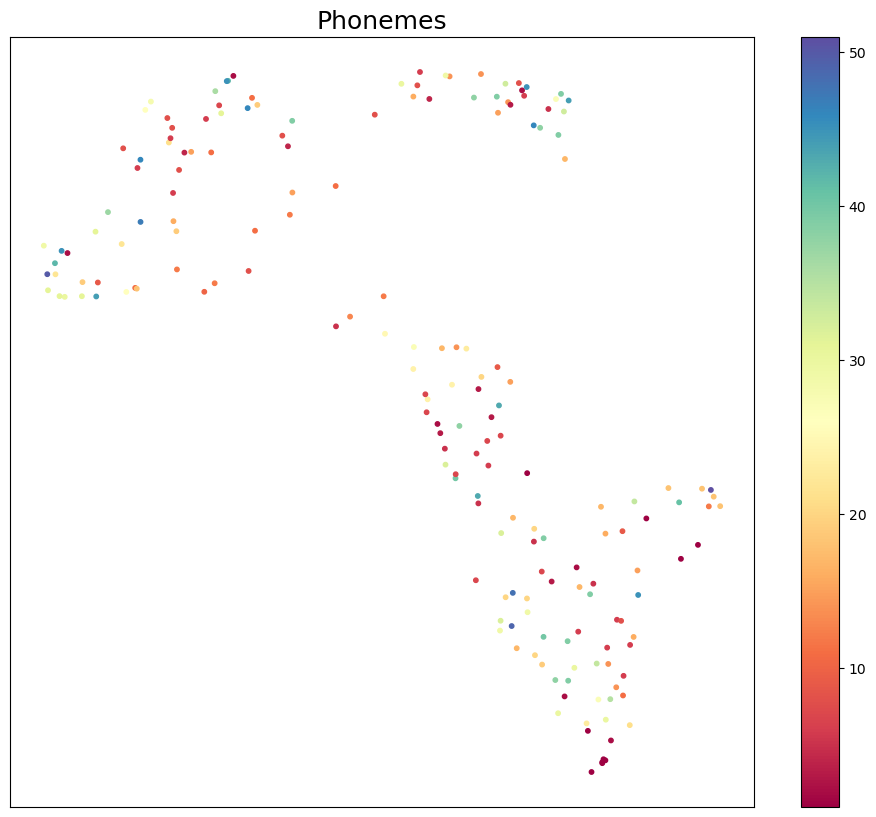

In [262]:
plot_umap(files_searching, weighted_average_phoneme_length)

C:\Users\sashe\anaconda3\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


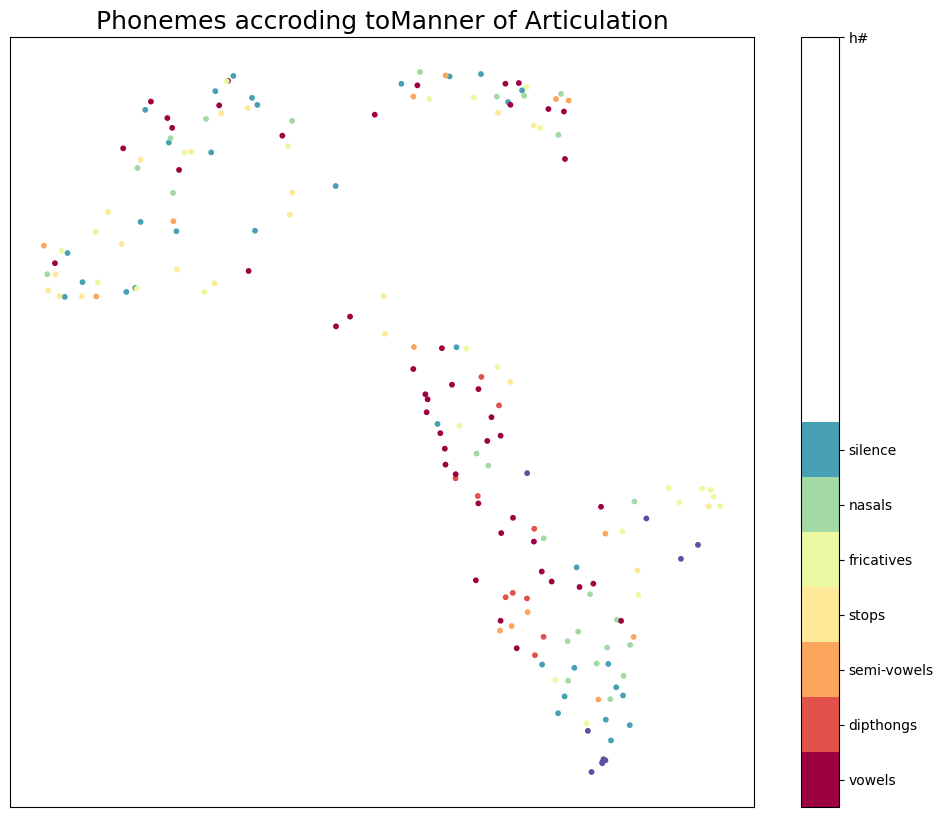

In [269]:
manner_of_articulation_map = {"vowels":{"iy","ih", 'eh', 'ae', 'aa', 'ah', 'ao', 'uh', 'uw', 'ux', 'ax', 'ax-h', 'ix'},
                             "dipthongs":{'ey', 'aw', 'ay', 'oy', 'ow'},
                             "semi-vowels": {'l', 'el', 'r', 'w', 'y', 'er', 'axr'},
                             "stops": {'b', 'd', 'g', 'p', 't', 'k', 'jh', 'ch'},
                             "fricatives": {'s', 'sh', 'z', 'zh', 'f', 'th', 'v', 'dh', 'hh', 'hv'},
                             "nasals": {'m', 'em', 'n', 'nx', 'ng', 'eng', 'en'},
                             "silence": {'dx', 'bcl', 'dcl', 'gcl', 'pcl', 'tcl', 'kcl', 'h', 'pau', 'epi', 'q'},
                             "h#": {"h#"}}
plot_umap(files_searching, weighted_average_phoneme_length, manner_of_articulation_map, "Manner of Articulation")

# Zmuv normalization

In [57]:
# Get the mean feature, the average, everything from post two weeks. 
'''
look over data.
use matlab to understand how the data opens up


Get mean and standard deviation of each phoneme class.
	5. Perhaps visualize/plot the average phoneme for each phoneme class.
	6. For a phoneme, normalize by class: subtract from the mean and divide by standard deviation. And time align.
	7. Visualize the normalized features.
Look at the difference in pattern between normalized and un-normalized features.
'''

'\nlook over data.\nuse matlab to understand how the data opens up\n\n\nGet mean and standard deviation of each phoneme class.\n\t5. Perhaps visualize/plot the average phoneme for each phoneme class.\n\t6. For a phoneme, normalize by class: subtract from the mean and divide by standard deviation. And time align.\n\t7. Visualize the normalized features.\nLook at the difference in pattern between normalized and un-normalized features.\n'

## Test Zmuv normalization and visualization for one phoneme class

In [ ]:
'''
edit and test below. to take output from get_phonemes_from_single_file and get the phonemes needed.
'''

In [271]:
def get_instances_of_phoneme_from_single_file(input_filename_or_file_phoneme_features_dictionary, phoneme, intended_phoneme_feature_matrix_length=None):
    '''
    this returns a numpy matrix of features of a phoneme class of a particular length (padded with nans if data is less than)
    inputs:
        filename (str): the input file
        phoneme (str): the phoneme class (assuming working with timit database)
        intended_phoneme_feature_matrix_length (int): the matrix length intended, such as a weighted average of the phoneme class lengths. if the features are not up to this length, it will be padded
        
        returns:
        numpy matrix of features of a phoneme class of a particular length (padded with nans if data is less than)
        OR 
        none if phoneme does not occur in file at all
    '''
    if type(input_filename_or_file_phoneme_features_dictionary)==str:
        if intended_phoneme_feature_matrix_length==None:
            raise Exception("If you are inputting a file to this function, you must also give a 'intended_phoneme_feature_matrix_length' value.")
        phoneme_features_dict = get_phonemes_from_single_file(input_filename_or_file_phoneme_features_dictionary, intended_phoneme_feature_matrix_length)
    else:
        phoneme_features_dict = input_filename_or_file_phoneme_features_dictionary
        
    if phoneme in phoneme_features_dict:
        return phoneme_features_dict[phoneme]
    else:
        return

In [272]:
# testing function
filename = 'Y:/personal/ojuba.mezisashe/timit_dp_test_extract_features/TRAIN/DR1/FCJF0/SI648.txt'
_ = get_instances_of_phoneme_from_single_file(filename, "h#", 34)
# np.array(_, dtype="float64").shape

In [119]:
phoneme = "aa"
average_phoneme_class_length = int(average_phoneme_lengths[phoneme])
feature_matrix = []

for file in files_searching:
    feature_matrix.extend(get_instances_of_phoneme_from_single_file(file, phoneme, average_phoneme_class_length))
feature_matrix = np.array(feature_matrix, dtype="float64")

In [143]:
def zmuv_normalize_phoneme_class(phoneme_class_features_matrix):
    '''
    return the normalized feature class of matrix phoneme_class_features_matrix, the mean and standard deviations
    inputs:
        phoneme_class_features_matrix (np.array): a 3d feature matrix of various instances of a phoneme. The phonemes instances are stacked on the z (?) axis
    returns:
        normalized_features (np.array): the normalized feature matrix 
        phoneme_mean (np.array):  the average feature (when nan values are ignored)
        phoneme_std (np.array):  the standard deviation (when nan values are ignored)
    '''
    phoneme_mean, phoneme_std = np.nanmean(feature_matrix,0),np.nanstd(feature_matrix,0)
    normalized_features = (phoneme_class_features_matrix - phoneme_mean)/(phoneme_std)
    
    return normalized_features, phoneme_mean, phoneme_std

In [144]:
feature_matrix_normed, phoneme_mean, phoneme_std = zmuv_normalize_phoneme_class(feature_matrix)

In [ ]:
'''

decouple getting features rolled out from plotting umap (in function) - FINISH THIS
    should get and save average and std? for each feature class?
make it possible to get features normalized
plot

email dr mainsah

change kevin's code in your directory to write to another file. 
extract features on whole dataset on the laptop with gpu

fix changed txt files in kevin's dataset

check other tasks
'''

In [292]:
# get averages and stds using the weighted total average length
output_folder = "average_and_std_phoneme_feature/weighted_average_total/" ### CHANGE THIS
for phoneme in ALL_PHONEMES:
    for file in files_searching:
        try:
            feature_matrix.extend(get_instances_of_phoneme_from_single_file(file, phoneme, weighted_average_phoneme_length))
        except:
            pass
    feature_matrix = np.array(feature_matrix, dtype="float64")
    feature_matrix_normed, phoneme_mean, phoneme_std = zmuv_normalize_phoneme_class(feature_matrix)
    np.savetxt(output_folder+phoneme+"_average.txt", phoneme_mean)
    np.savetxt(output_folder+phoneme+"_std.txt", phoneme_std)

In [ ]:
# get averages and stds using the average length per phoneme class
output_folder = "average_and_std_phoneme_feature/average_per_class/" ### CHANGE THIS
for phoneme in ALL_PHONEMES:
    try:
        phoneme_average_length = average_phoneme_lengths[phoneme]
    except:
        continue
    for file in files_searching:
        try:
            feature_matrix.extend(get_instances_of_phoneme_from_single_file(file, phoneme, phoneme_average_length))
        except:
            pass
    feature_matrix = np.array(feature_matrix, dtype="float64")
    feature_matrix_normed, phoneme_mean, phoneme_std = zmuv_normalize_phoneme_class(feature_matrix)
    np.savetxt(output_folder+phoneme+"_average.txt", phoneme_mean)
    np.savetxt(output_folder+phoneme+"_std.txt", phoneme_std)

In [295]:
ALL_PHONEMES[49:]

['ng',
 'pau',
 'bcl',
 'pcl',
 'tcl',
 'epi',
 'q',
 'dcl',
 'h',
 'dx',
 'gcl',
 'kcl',
 'h#']